In [1]:
import numpy as np
import matplotlib as mpl
from os.path import isfile

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['legend.numpoints'] = 1
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(context="paper", style="ticks", palette="colorblind", color_codes=True, font_scale=1.5)
import pandas as pd

from pyFIT3D.modelling.stellar import SSPModels
from pyFIT3D.common.io import trim_waves, get_data_from_fits, get_wave_from_header
from pyFIT3D.common.constants import _SSP_OUTPUT_INDEX, __mask_elines_window__, __c__

latex_ppi = 72.0
latex_column_width_pt = 240.0
latex_column_width = latex_column_width_pt/latex_ppi
# latex_column_width = latex_column_width_pt/latex_ppi/1.4
latex_text_width_pt = 504.0
latex_text_width = latex_text_width_pt/latex_ppi
golden_mean = 0.5 * (1. + 5**0.5)
width = 8
aspect = 1/golden_mean
figsize = (width, width * aspect)

dtype_coeffs = [
    ('id','int'), ('age', 'float'), ('met', 'float'), ('coeff', 'float'), ('min_coeff', 'float'),
    ('l_ML', 'float'), ('AV', 'float'), ('norm_coeff', 'float'), ('err_coeff', 'float'),
]

dtype_props = []
for k in _SSP_OUTPUT_INDEX.keys():
    dtype_props.append((k, 'float'))

def calc_weights(df):
    """Return the pivot matrix with coefficients and the
    marginal weights in age and metallicity"""
    coeffs = df.pivot_table(index="AGE", columns="MET", values="COEFF")

    met = coeffs.columns.values

    met_weights = coeffs / coeffs.sum(axis="columns", skipna=True).values[:,None]
    met_weights = met_weights.values[:,:,None].transpose(0,2,1)

    age_weights = coeffs.sum(axis="columns", skipna=True)
    age_weights /= np.nansum(age_weights)
    age_weights = age_weights.values[None,:]

    return coeffs, met_weights, age_weights

In [2]:
name = 'manga-7495-12704'

# LOAD FILES
auto_ssp_output_filename = f'auto_ssp.{name}.int.out'
coeffs_filename = 'tables/coeffs_' + auto_ssp_output_filename
spec_filename = 'tables/output.' + auto_ssp_output_filename + '.fits.gz'
auto_ssp_output_filename = 'tables/'+auto_ssp_output_filename
coeffs_data = np.loadtxt(fname=coeffs_filename, dtype=dtype_coeffs)
properties_data = np.loadtxt(fname=auto_ssp_output_filename, dtype=dtype_props, delimiter=',')
spec__Tw, spec_header = get_data_from_fits(spec_filename, header=True)
wave__w = get_wave_from_header(spec_header, wave_axis=1)

# LOAD MASKS
elines_mask_filename = '/disk-a/sanchez/ppak/legacy/emission_lines.txt'
mask_list_filename = '/disk-a/sanchez/ppak/legacy/mask_elines.txt'
eline_half_range = __mask_elines_window__
e_masks = None
sigma_mean_AA = properties_data['sigma']*5000/__c__
z_fact = 1 + properties_data['redshift']
if (elines_mask_filename is not None) and isfile(elines_mask_filename):
    e_w = np.loadtxt(elines_mask_filename, usecols=(0))
    e_masks = np.empty((e_w.size, 2), dtype=np.float)
    eline_half_range *= sigma_mean_AA
    if eline_half_range < 4:
        eline_half_range = 4
    e_masks[:,0] = e_w*z_fact - eline_half_range
    e_masks[:,1] = e_w*z_fact + eline_half_range

masks = None
if (mask_list_filename is not None) and isfile(mask_list_filename):
    masks = np.loadtxt(mask_list_filename)


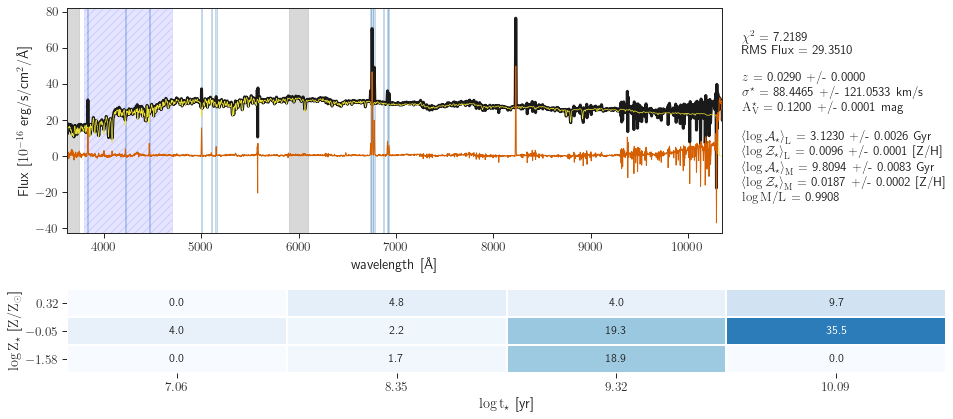

In [5]:
nl_wl_range = [3800, 4700]
# wl_range = [3800, 10000]
wl_range = [wave__w[0], wave__w[-1]]
cmap = 'Blues'
center = None
vmin = 0.1
vmax = 50
fmt = '.1f'
percent = True
wlmsk = np.ones_like(wave__w, dtype='bool')
if wl_range is not None:
    wlmsk = trim_waves(wave__w, wl_range)

f = plt.figure()
width = 2*latex_text_width
f.set_size_inches(width, 0.7*width*aspect)

gs = f.add_gridspec(3,4)
ax_sp = f.add_subplot(gs[:2, :3])
ax = f.add_subplot(gs[2, :])

ax_lw = f.add_subplot(gs[:2, 3])
ax_lw.set_axis_off()
resume_text = '{gal}\nAge LW = '

msg = r'$\chi^2$ = %6.4f' % properties_data['chi_joint']
msg += '\n'
msg += r'RMS Flux = %6.4f' % properties_data['med_flux']
msg += '\n'
msg += '\n'
msg += r'$z$ = %6.4f +/- %.4f' % (properties_data['redshift'], properties_data['e_redshift'])
msg += '\n'
msg += r'$\sigma^\star$ = %6.4f +/- %0.4f' % (properties_data['sigma'], properties_data['e_sigma'])
# if sigma_inst is None:
#     msg += r' \AA'
# else:

# \mathcal{A}_\star
# \mathcal{Z}_
msg += ' km/s'
msg += '\n'
msg += r'${\rm A}_{\rm V}^\star$ = %6.4f +/- %0.4f mag' % (properties_data['AV_min'], properties_data['e_AV_min'])
msg += '\n'
msg += '\n'
msg += r'$\left< \log \mathcal{A}_\star \right>_{\rm L}$ = %6.4f +/- %0.4f Gyr' % (properties_data['age_min'], properties_data['e_age_min'])
msg += '\n'
msg += r'$\left< \log \mathcal{Z}_\star \right>_{\rm L}$ = %6.4f +/- %0.4f [Z/H]' % (properties_data['met_min'], properties_data['e_met_min'])
msg += '\n'
msg += r'$\left< \log \mathcal{A}_\star \right>_{\rm M}$ = %6.4f +/- %0.4f Gyr' % (properties_data['age_min_mass'], properties_data['e_age_min_mass'])
msg += '\n'
msg += r'$\left< \log \mathcal{Z}_\star \right>_{\rm M}$ = %6.4f +/- %0.4f [Z/H]' % (properties_data['met_min_mass'], properties_data['e_met_min_mass'])
msg += '\n'
msg += r'$\log {\rm M}/{\rm L}$ = %6.4f' % properties_data['lml']

ax_lw.text(0.02, 0.9, msg, transform=ax_lw.transAxes, ha='left', va='top', fontsize=13)
in_spec = spec__Tw[0][wlmsk]
out_spec = spec__Tw[1][wlmsk]
out_spec_joint = spec__Tw[2][wlmsk]
res = in_spec - out_spec
wl = wave__w[wlmsk]
ax_sp.set_ylabel('Flux [$10^{-16}$ erg/s/cm$^2/$\AA]')
ax_sp.set_xlabel('wavelength [\AA]')

#print(masks)
for msk in masks:
    if msk[0] < wl_range[1]:
        ax_sp.axvspan(msk[0], msk[1], alpha=0.3, color='gray')

_c = plt.cm.get_cmap(cmap)(0.8)

for msk in e_masks:
    l, r = msk
#    print(l,r)
    if r > wl_range[1]:
        r = wl_range[1]
    if l > wl_range[0]:
        ax_sp.axvspan(l, r, alpha=0.2, color=_c)

ax_sp.axvspan(nl_wl_range[0], nl_wl_range[1], alpha=0.1, color='blue', hatch='///')
ax_sp.plot(wl, in_spec, '-k', lw=3)
ax_sp.plot(wl, out_spec, '-y', lw=0.7)
ax_sp.plot(wl, (in_spec - out_spec), '-r', lw=1)

# HEATMAP
d_to_df = dict(ID=coeffs_data['id'], AGE=coeffs_data['age'], MET=coeffs_data['met'], COEFF=coeffs_data['min_coeff'])
df = pd.DataFrame(data=d_to_df)
idx = np.lexsort((df.MET, df.AGE))
df = df.iloc[idx]
df.MET = df.MET.apply(lambda x: np.log10(x/0.019))
df = df.reset_index(drop=True)
pivot_weights, met_weights, age_weights = calc_weights(df)
pivot_weights = pivot_weights.T
pivot_weights.sort_index(axis="index", ascending=False, inplace=True)
percent=True
xlabels = list(map(lambda v: "$%5.2f$"%v, np.log10(pivot_weights.columns*1e9)))
ylabels = list(map(lambda v: "$%5.2f$"%v, pivot_weights.index))
sns.heatmap((pivot_weights / pivot_weights.values.sum() * 100 if percent else pivot_weights), cmap=cmap, center=center, vmin=vmin, vmax=vmax, square=False, linewidths=1.0,
            linecolor="w", annot=True, fmt=fmt, annot_kws={"fontsize":12}, cbar=False, ax=ax, xticklabels=xlabels, yticklabels=ylabels)
ax.set_xlabel(r'$\log {\rm t}_\star$ [yr]')
ax.set_ylabel(r'$\log {\rm Z}_\star$ [${\rm Z}/{\rm Z}_\odot$]')
ax_sp.set_xlim(wl_range)
f.tight_layout()
figname=f'ana_spec_auto_ssp.{name}.int.out'
f.savefig(figname+".pdf", transparent=False, facecolor='white', edgecolor='white')